In [7]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile
import pickle
import random
import os
import gams_magic

# Create link file

In [2]:
#read link data
road_file_path = os.path.join('..','road_file.csv')
road_file = pd.read_csv(road_file_path,names=["RDWY_LINK_ID","REF_SITE_FROM_ID","REF_SITE_TO_ID"])

In [3]:
road_file

,RDWY_LINK_ID,REF_SITE_FROM_ID,REF_SITE_TO_ID
0,4818580,1661200,1660820
1,4819008,1661678,1661705
2,4819009,1661704,1661705
3,4819014,1661723,1661697
4,4819015,1661705,1661723
...,...,...,...
3127,5571520,1663210,1663276
3128,5571521,1661558,1661551
3129,5571522,1661551,1661558
3130,5571523,2016715,2005025


# read shape file

In [4]:

shape_path = os.path.join("..","transportation_data","Middleton_Cross_Plains","Features","Middleton_CrossPlains_OVLY.shp")
shape = shapefile.Reader(shape_path)
# #first feature of the shapefile
# feature = shape.shapeRecords()[0]
# first = feature.shape.__geo_interface__  
# print first # (GeoJSON format)
# {'type': 'LineString', 'coordinates': ((0.0, 0.0), (25.0, 10.0), (50.0, 50.0))}

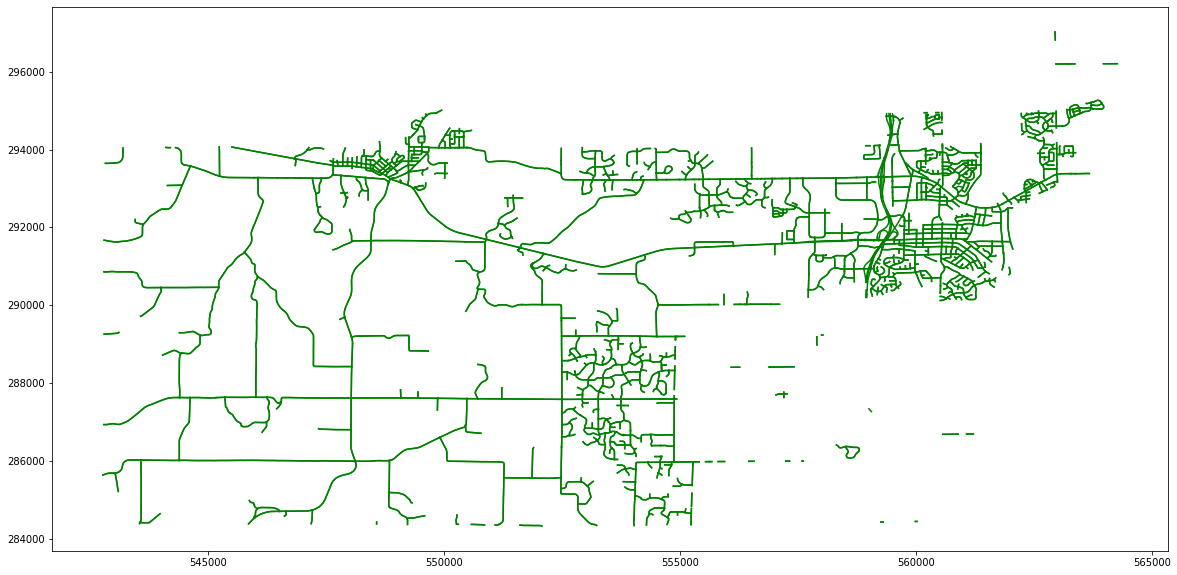

In [5]:
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()

all_roadId = list(road_file['RDWY_LINK_ID'])
for sp in shape.shapeRecords():
    road_id = sp.record[43]
    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
    plt.plot(x,y,'g')
    
plt.show()

# Temp : chosen road

In [58]:
# load reference point coordinate
reference_coordinate = None
reference_path = os.path.join("..","reference_coordinate")

with open(reference_path, 'rb') as f:
    reference_coordinate = pickle.load(f)


In [65]:
%reload_ext gams_magic
%gams_cleanup -k
%gams_reset

In [66]:
%%gams
$title shortest path try

option limcol = 0, limrow = 0, solprint = off;
set
    nodes
    roadID
;

alias (nodes,i,j);
$gdxin ../link_file.gdx
$loadm nodes=dim1 nodes=dim2
parameter distance(nodes,nodes);
$load  distance=link
$gdxin

$gdxin ../road_file.gdx
set road(roadID<,nodes,nodes);
$load  road=road
$gdxin


set arc(nodes,nodes);

arc(i,j) = no;
arc(i,j)$(distance(i,j) > 0.5) = yes;

parameter
    supply(nodes)
;

scalar origin,destination;
execseed = 1 + gmillisec(jnow);
origin = uniformint(1,card(nodes));
destination = uniformint(1,card(nodes));

supply(nodes)$(ord(nodes) = origin) = 1;

supply(nodes)$(ord(nodes) = destination) = -1;



free variable
    total_dist
;

integer variable
    flow(i,j)
;

flow.lo(i,j) = 0

equation
    balance(nodes)
    objective_shortestPath
;


balance(i)..
    sum(arc(i,j), flow(i,j)) - sum(arc(j,i), flow(j,i)) =e= supply(i);
    
objective_shortestPath..
    total_dist =e= sum(arc(i,j),flow(i,j)*distance(i,j));
    


    


model shortestPath /all/;

solve shortestPath using mip minimizing total_dist;
    

set roadChosen(roadID);

roadChosen(roadID) = no;

roadChosen(roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosen(roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;


display roadChosen;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),46617.0,1319,3133,MIP,CPLEX,0.048


In [67]:
%gams_pull roadChosen
%gams_pull supply

In [68]:
supply

[('1664349', 1.0), ('1662307', -1.0)]

In [69]:
chosen_road = [int(road) for road in roadChosen]

origin = None
destination = None
for i in supply:
    if i[1] == 1:
        origin = int(i[0])
    else:
        destination = int(i[0])

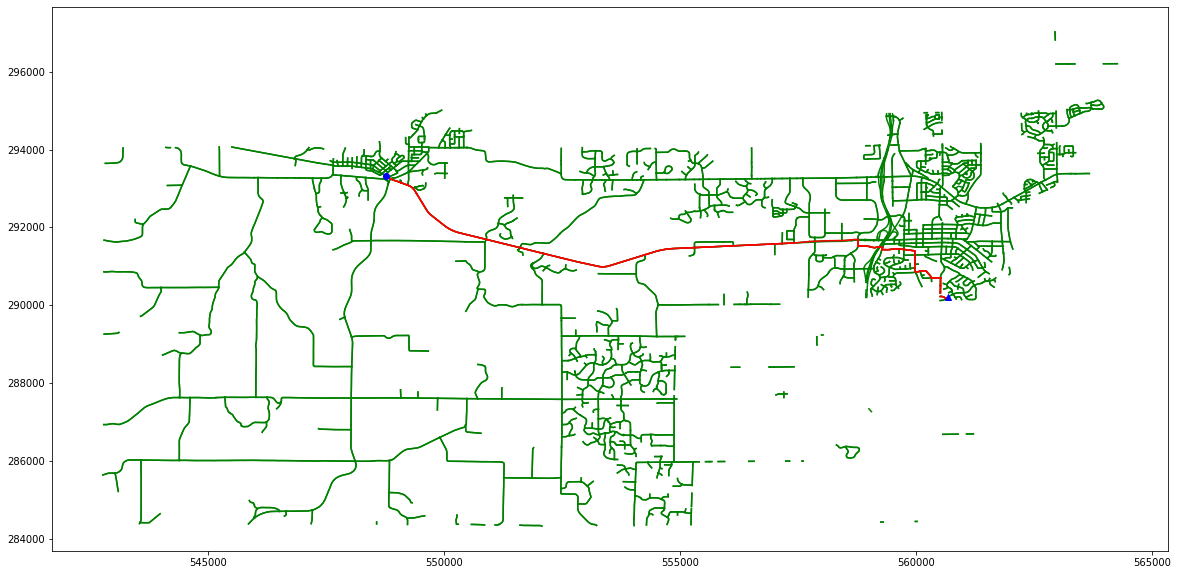

In [70]:
plt.rcParams["figure.figsize"] = (20,10)
chosen = []
plt.figure()

#plot original map 
for sp in shape.shapeRecords():
    road_id = sp.record[43]
    
    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
    
    if road_id in chosen_road:
        chosen.append((x,y))
    plt.plot(x,y,'g')
    

    
#plot shortest path
for subpath in chosen:
    plt.plot(subpath[0],subpath[1],'r')    
    
plt.plot(reference_coordinate[origin][0], reference_coordinate[origin][1],'b^')
plt.plot(reference_coordinate[destination][0], reference_coordinate[destination][1],'bo')



plt.show()